In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from dataset import *
from save_load import *
from NN_library.PINN import *
from NN_library.train_primal_VPINN import *
from NN_library.train_dual_VPINN import *
from matplotlib.tri import Triangulation
from utility import *
%load_ext autoreload
%autoreload 2

Using device: cuda


In [2]:
data = dataset_grid(129, [0, 2*np.pi], [0, 2*np.pi])
loaders = get_loaders_Sobol(data, 129**2)

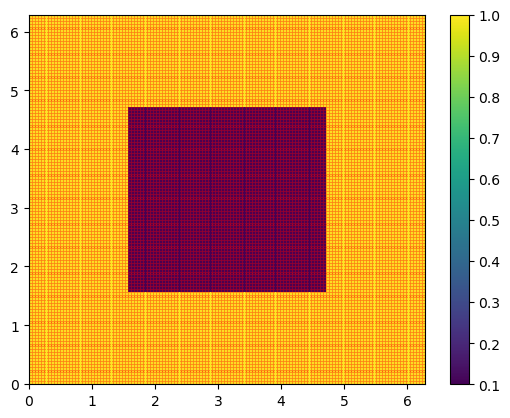

In [3]:
L = 2*np.pi
N = 512 # number of nodes in each direction including the border
x = np.linspace(0, L, N, endpoint=True)
y = np.linspace(0, L, N, endpoint=True)

XY = np.meshgrid(x, y)
grid_data = torch.tensor(np.vstack((XY[0].flatten(), XY[1].flatten())).T, dtype=torch.float, device=dev)

def a_function(x,y):
    a = np.where((x>np.pi/2)&(x<3*np.pi/2)&(y>np.pi/2)&(y<3*np.pi/2), 0.1, 1)
    return a

def A(x):
    a = torch.where((x[:,0]>torch.pi/2)&(x[:,0]<3*torch.pi/2)&(x[:,1]>torch.pi/2)&(x[:,1]<3*torch.pi/2), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a * I
    return A

def A_inv(x):  
    a = torch.where((x[:,0]>torch.pi/2)&(x[:,0]<3*torch.pi/2)&(x[:,1]>torch.pi/2)&(x[:,1]<3*torch.pi/2), 0.1, 1).view(-1,1,1)
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = (1 / a) * I
    return A

eps=1
def A_interp(x): 
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = a.view(-1,1,1) * I
    return A

def A_interp_inv(x):  
    x_dir = 0.5 + 0.5*torch.tanh(eps*torch.sin(x-torch.pi/2))
    a = 1 - 0.9*x_dir[:,0]*x_dir[:,1]
    I = torch.eye(2, device=dev).repeat(x.shape[0], 1, 1)
    A = 1/a.view(-1,1,1) * I
    return A

def H1(x):
    H = torch.zeros_like(x)
    H[:,0] = 1.
    return H

Z = a_function(XY[0].flatten(), XY[1].flatten())
plt.pcolormesh(XY[0], XY[1], Z.reshape(N, N))
plt.colorbar()
plt.scatter(data[:,0], data[:,1], s = 0.1, c='r')

# Test functions

## Spectral

In [5]:
func1 = lambda x, m, n: torch.cos(m*x[:,0]+n*x[:,1])
func2 = lambda x, m, n: torch.sin(m*x[:,0]+n*x[:,1])
N_x = 6
N_y = 6
test_functions = []

for m in range(N_x):
    for n in range(N_y):
        test_functions.append(lambda x, m=m, n=n: func1(x, m, n))
        test_functions.append(lambda x, m=m, n=n: func2(x, m, n))

test_functions = test_functions[2:]
N_test = len(test_functions)

In [25]:
# compute G if needed
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(dev)
x = x.to(dev).requires_grad_(True)

G = torch.zeros((N_test, N_test))
g_test = []
for i in range(N_test):
    y_test = test_functions[i](x)
    grad_test = torch.autograd.grad(
                outputs=y_test, inputs=x,
                grad_outputs=torch.ones_like(y_test)
            )[0]
    g_test.append(grad_test.detach())

for i in range(N_test):
    intgr = compute_int(areas, tri, g_test[i], g_test[i]).detach()
    G[i,i] = intgr

torch.save(G, "G_primal_spectral.pt")
G_inv = torch.linalg.inv(G).to(dev)

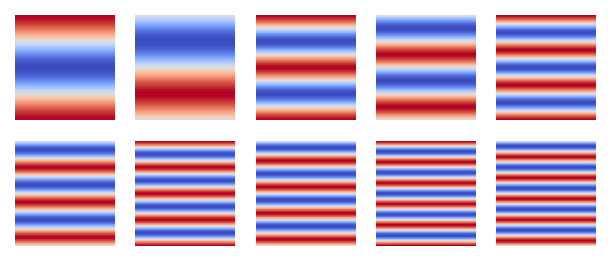

In [26]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize=(5,2), dpi=150)
for i in range(10):
    axs.flat[i].pcolormesh(XY[0], XY[1], test_functions[i](grid_data).reshape(N, N).cpu().detach(), cmap='coolwarm')
    axs.flat[i].set_axis_off()

# Primal PINN

In [6]:
net_primal = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_primal.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 1e-4, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VSPINN_primal_{total_params}_{N_test}'}

Number of parameters: 65


In [7]:
net_primal = load_network(net_primal, args['name']+'_39999', args)
net_primal = net_primal.to(dev)

In [28]:
losses_train, losses_val = train_primal(net_primal, loaders, args, A, H1, test_functions, G_inv, L)

Epoch: 0 mean train loss:  3.54070759e+00, mean val. loss:  8.22642088e-01
Epoch: 1 mean train loss:  3.53444266e+00, mean val. loss:  8.22438717e-01
Epoch: 2 mean train loss:  3.52819347e+00, mean val. loss:  8.22235882e-01
Epoch: 3 mean train loss:  3.52196026e+00, mean val. loss:  8.22033525e-01
Epoch: 4 mean train loss:  3.51574349e+00, mean val. loss:  8.21831763e-01
Epoch: 5 mean train loss:  3.50954366e+00, mean val. loss:  8.21630418e-01
Epoch: 6 mean train loss:  3.50336051e+00, mean val. loss:  8.21429729e-01
Epoch: 7 mean train loss:  3.49719477e+00, mean val. loss:  8.21229398e-01
Epoch: 8 mean train loss:  3.49104667e+00, mean val. loss:  8.21029782e-01
Epoch: 9 mean train loss:  3.48491573e+00, mean val. loss:  8.20830703e-01
Epoch: 10 mean train loss:  3.47880244e+00, mean val. loss:  8.20632160e-01
Epoch: 11 mean train loss:  3.47270775e+00, mean val. loss:  8.20434153e-01
Epoch: 12 mean train loss:  3.46663070e+00, mean val. loss:  8.20236862e-01
Epoch: 13 mean train l

KeyboardInterrupt: 

In [14]:
np.save(f'NN_library/training_data/square/VSPINN_primal_{total_params}_{N_test}', np.vstack([losses_train, losses_val]))

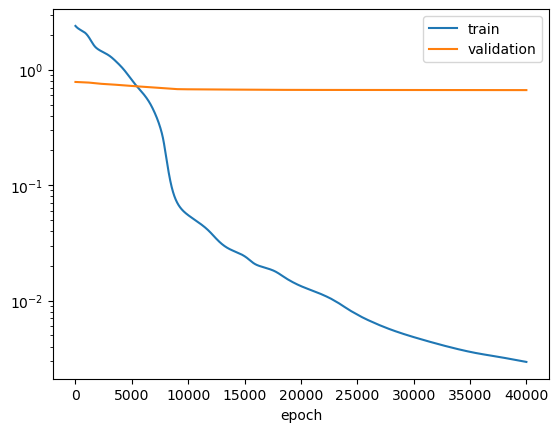

In [13]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [29]:
U1 = net_primal(grid_data).detach().cpu()
error_1, _, _ = PDE_loss(grid_data, net_primal, A, H1)

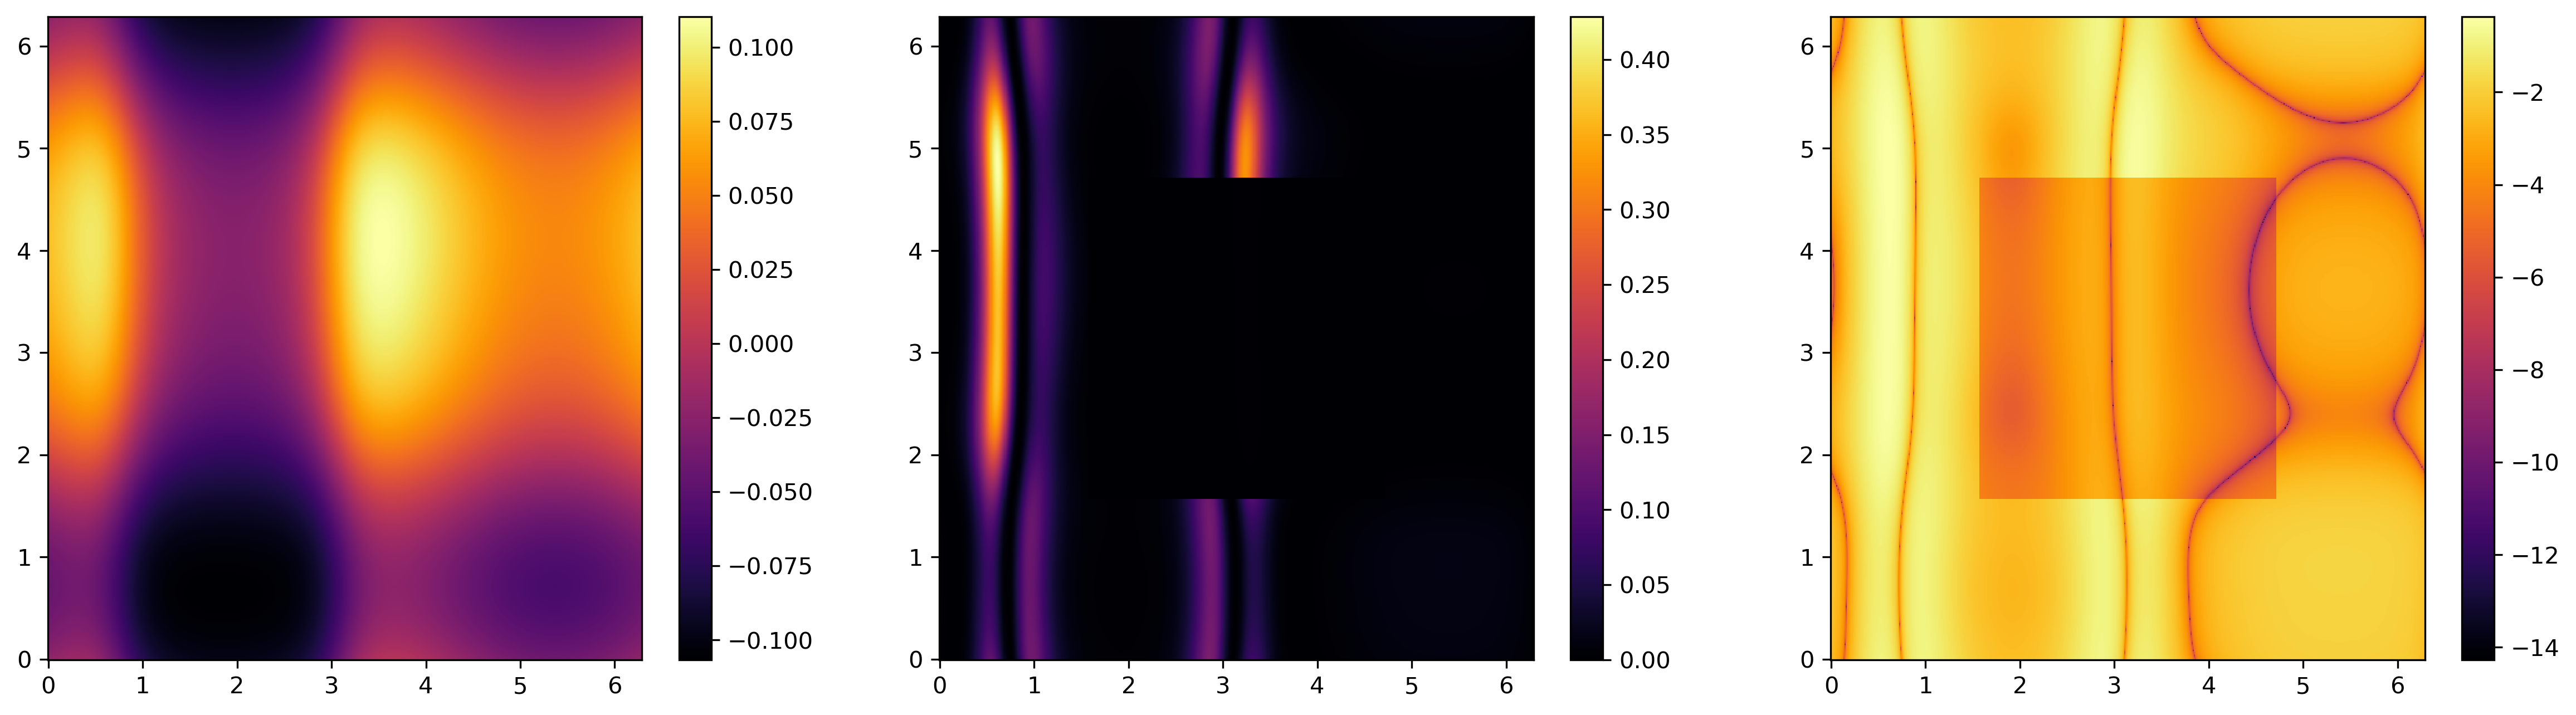

In [30]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U1.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_1.reshape(N, N).detach().cpu(), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], np.log10(error_1.reshape(N, N).detach().cpu()), cmap='inferno')
fig.colorbar(pos3, ax=axs[2])

In [14]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])
x_rot = torch.fliplr(x)

_, q1, gH = PDE_loss(x, net_primal, A, H1)
bound_1 = compute_estimate(areas, tri, q1, gH, L).detach()[0].item()
print(bound_1)

U1 = net_primal(x)
U2 = net_primal(x_rot)
bound_2 = compute_bound_primal(U1, U2, tri, x, A, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_u_VSPINN_{total_params}_{N_test}.npy', (bound_1, bound_2))

0.6685917973518372
0.6599591652464999


# Dual PINN

In [8]:
net_dual = PINN(n_periodic=2, n_hidden=4, n_layers=1, period_len=L)
total_params = sum(p.numel() for p in net_dual.parameters())
print(f"Number of parameters: {total_params}")
args = {'lr' : 0.0001, 'epochs' : 40000, 'dev' : dev, 'name' : f'NN_library/VPINN/square/VSPINN_dual_{total_params}_{N_test}'}

Number of parameters: 65


In [9]:
net_dual = load_network(net_dual, args['name']+'_39999', args)
net_dual = net_dual.to(dev)

In [12]:
losses_train, losses_val = train_dual(net_dual, loaders, args, A_inv, H1, test_functions, G_inv, L)

Epoch: 0 mean train loss:  2.27996658e+02, mean val. loss:  3.14164340e-01
Epoch: 1 mean train loss:  2.27979919e+02, mean val. loss:  3.14164877e-01
Epoch: 2 mean train loss:  2.27963226e+02, mean val. loss:  3.14165413e-01
Epoch: 3 mean train loss:  2.27946533e+02, mean val. loss:  3.14165920e-01
Epoch: 4 mean train loss:  2.27929962e+02, mean val. loss:  3.14166486e-01
Epoch: 5 mean train loss:  2.27913376e+02, mean val. loss:  3.14166993e-01
Epoch: 6 mean train loss:  2.27896851e+02, mean val. loss:  3.14167529e-01
Epoch: 7 mean train loss:  2.27880356e+02, mean val. loss:  3.14168036e-01
Epoch: 8 mean train loss:  2.27863922e+02, mean val. loss:  3.14168572e-01
Epoch: 9 mean train loss:  2.27847565e+02, mean val. loss:  3.14169139e-01
Epoch: 10 mean train loss:  2.27831223e+02, mean val. loss:  3.14169675e-01
Epoch: 11 mean train loss:  2.27814972e+02, mean val. loss:  3.14170212e-01
Epoch: 12 mean train loss:  2.27798706e+02, mean val. loss:  3.14170718e-01
Epoch: 13 mean train l

KeyboardInterrupt: 

In [ ]:
np.save(f'NN_library/training_data/square/VSPINN_dual_{total_params}_{N_test}', np.vstack([losses_train, losses_val]))

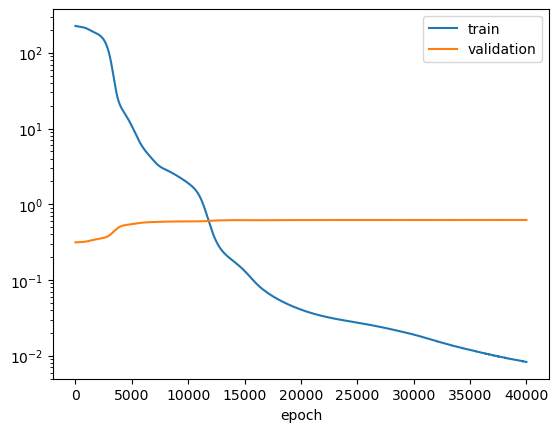

In [ ]:
plt.plot(losses_train)
plt.plot(losses_val)
plt.xlabel('epoch')
plt.legend(['train', 'validation'])
plt.yscale('log')

In [ ]:
U2 = net_dual(grid_data).detach().cpu()
error_2, q = PDE_loss_dual(grid_data, net_dual, A_inv, H1)

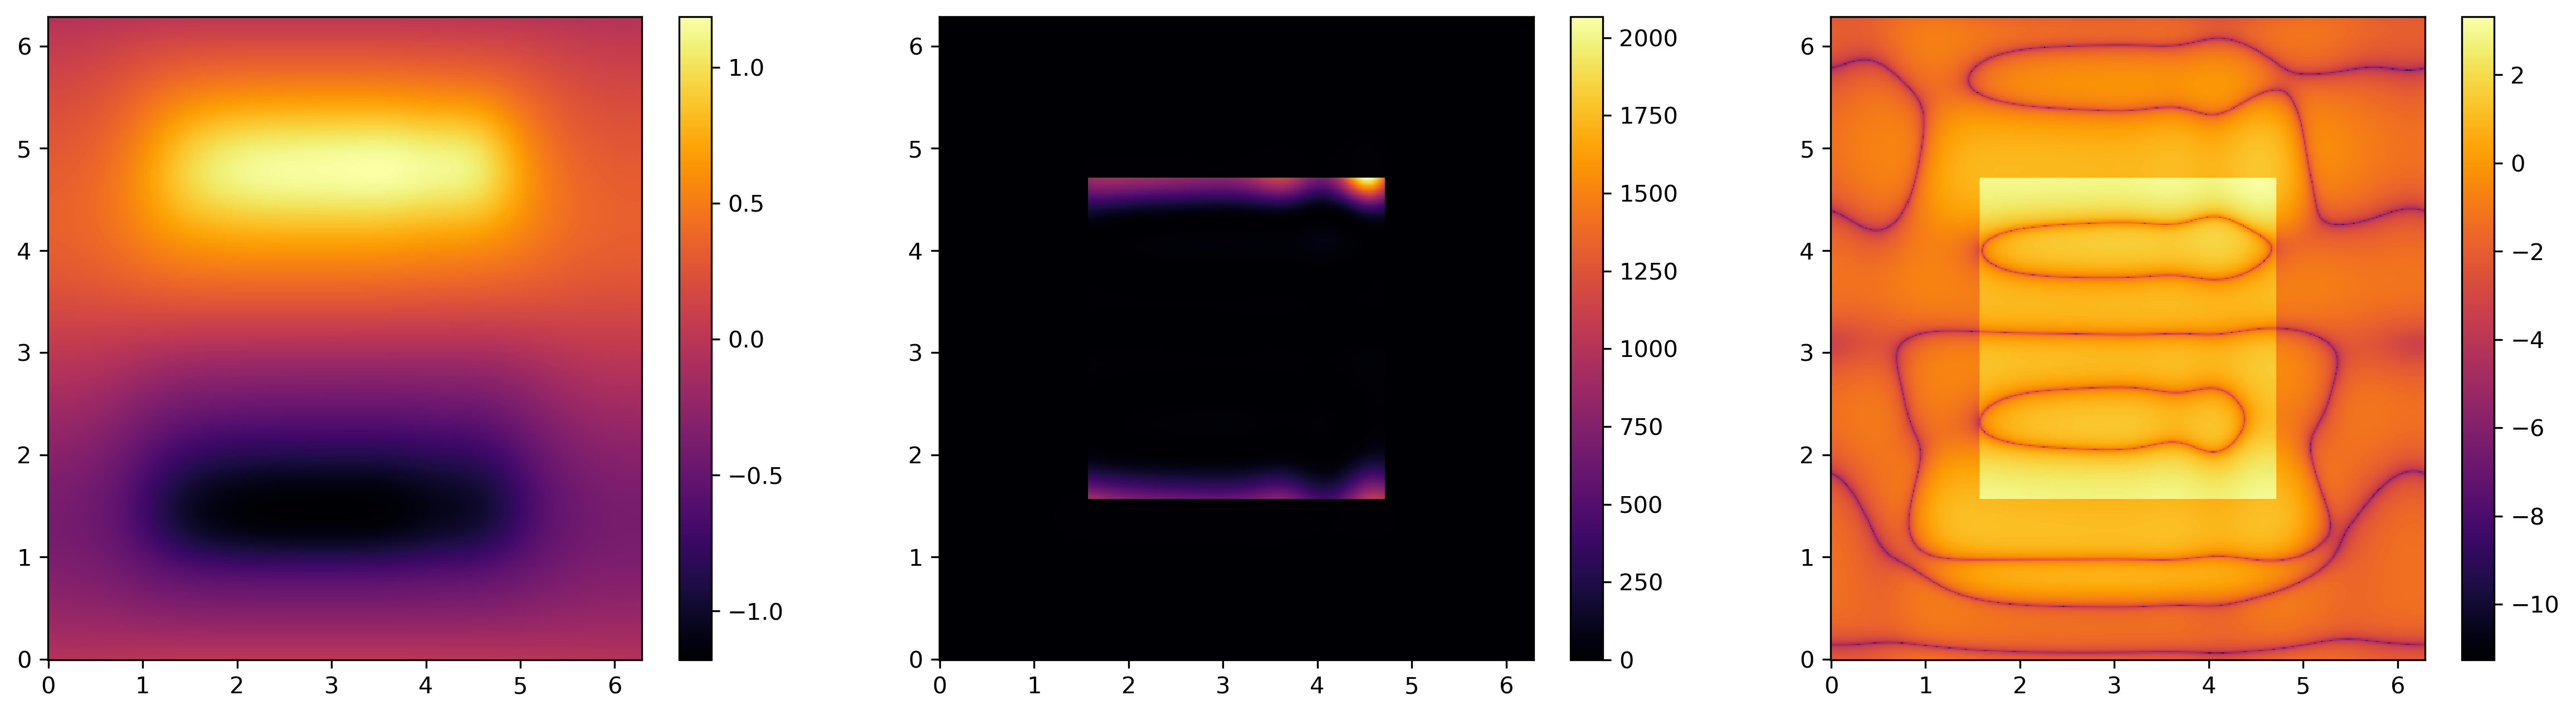

In [25]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(19.5,5), dpi=300)
pos1 = axs[0].pcolormesh(XY[0], XY[1], U2.reshape(N, N), cmap='inferno')
fig.colorbar(pos1, ax=axs[0])
pos2 = axs[1].pcolormesh(XY[0], XY[1], error_2.detach().cpu().reshape(N, N), cmap='inferno')
fig.colorbar(pos2, ax=axs[1])
pos3 = axs[2].pcolormesh(XY[0], XY[1], np.log10(error_2.detach().cpu().reshape(N, N)), cmap='inferno')
fig.colorbar(pos3, ax=axs[2])

In [17]:
for i, x in enumerate(loaders['train']):
    areas, tri = get_areas(x)
    areas = areas.to(args['dev'])
x = x.to(args['dev'])
x_rot = torch.fliplr(x)
x_rot[:,1] = -x_rot[:,1]

_, q2, gH = PDE_loss_dual(x, net_dual, A_inv, H1)
bound_1 = compute_estimate(areas, tri, q2, gH, L).detach()[0].item()
print(1/bound_1)

W1 = net_dual(x)
W2 = net_dual(x_rot)

bound_2 = compute_bound_dual(W1, W2, tri, x, A_inv, L)[0,0]
print(bound_2)

np.save(f'bounds/square/A_l_VSPINN_{total_params}_{N_test}.npy', (1/bound_1, bound_2))

0.6170212406009092
0.6068546734374155


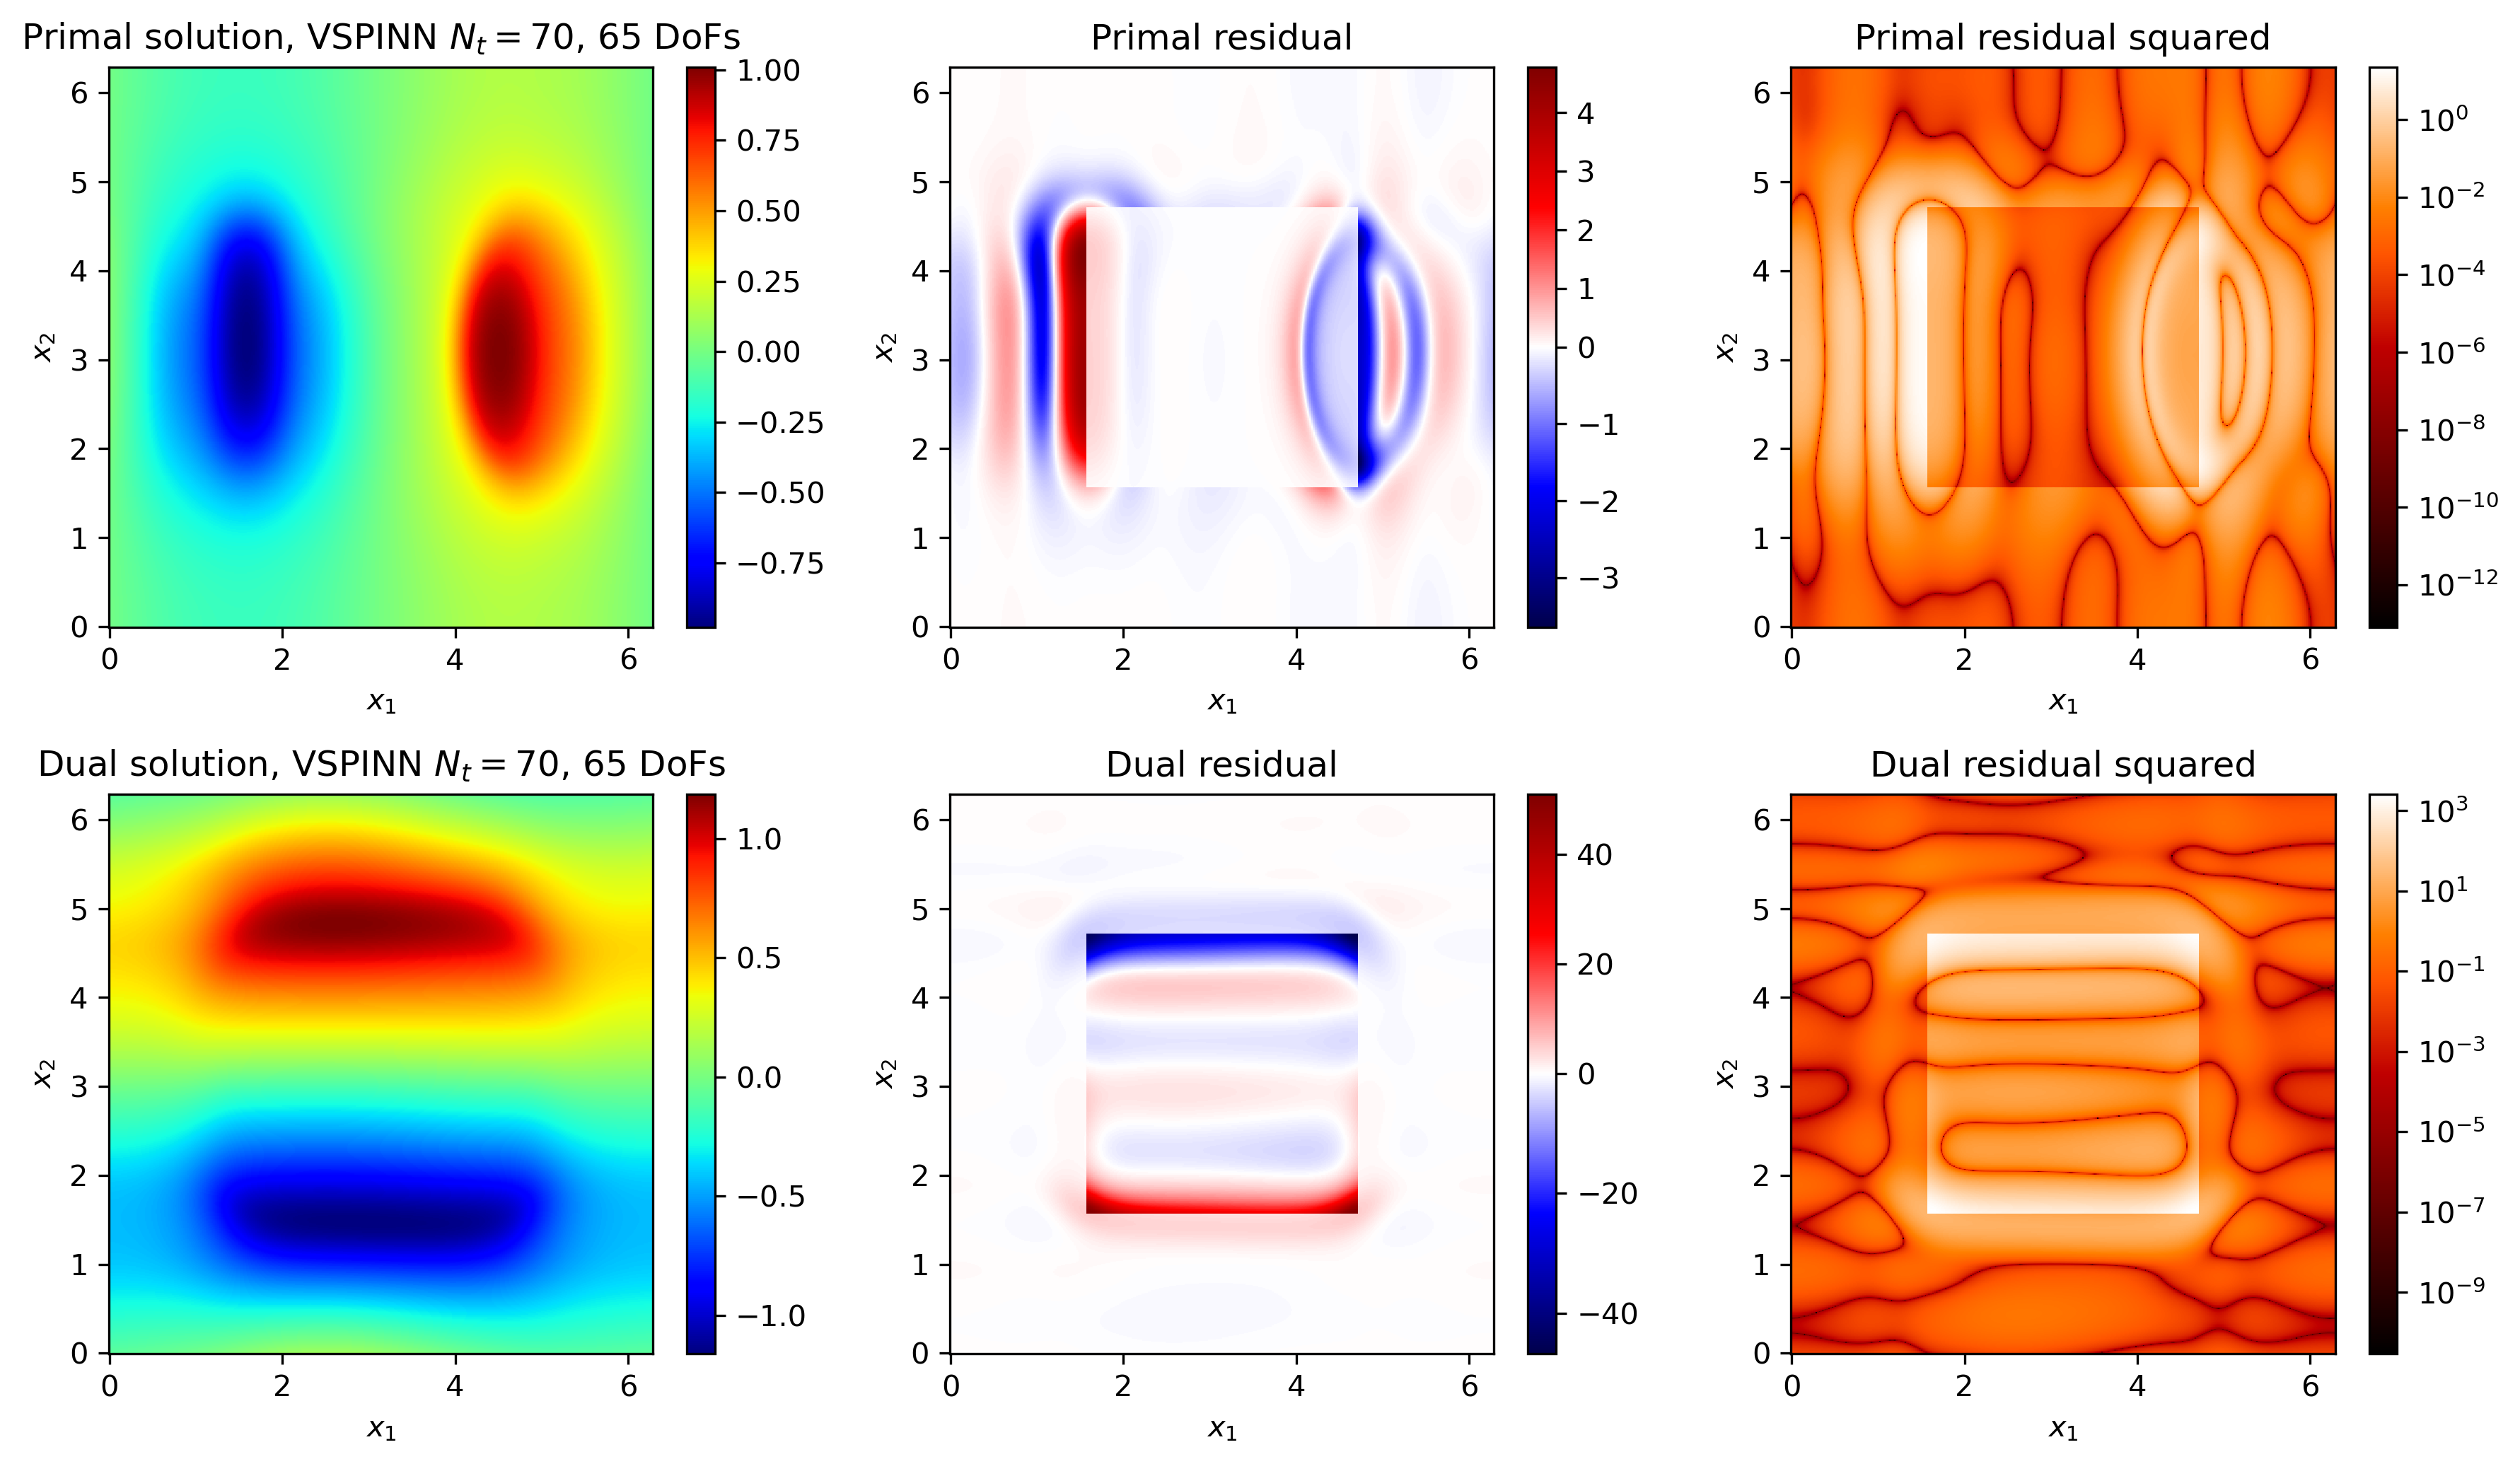

In [10]:
U1 = net_primal(grid_data).detach().cpu().reshape(N, N)
error_1_p, _, _ = PDE_loss(grid_data, net_primal, A, H1)
error_1_p = error_1_p.detach().cpu().reshape(N, N)
U2 = net_dual(grid_data).detach().cpu().reshape(N, N)
error_1_d, _, _ = PDE_loss_dual(grid_data, net_dual, A_inv, H1)
error_1_d = error_1_d.detach().cpu().reshape(N, N)

from matplotlib.colors import TwoSlopeNorm, LogNorm

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(12,7), dpi=300)

for i in range(6):
    axs.flat[i].set_xlabel('$x_1$')
    axs.flat[i].set_ylabel('$x_2$')

pos1 = axs[0,0].pcolormesh(XY[0], XY[1], U1, cmap='jet')
fig.colorbar(pos1, ax=axs[0,0])
pos2 = axs[1,0].pcolormesh(XY[0], XY[1], U2, cmap='jet')
fig.colorbar(pos2, ax=axs[1,0])

axs[0,0].set_title(f'Primal solution, VSPINN $N_t=70$, {total_params} DoFs')
axs[1,0].set_title(f'Dual solution, VSPINN $N_t=70$, {total_params} DoFs')


pos1 = axs[0,1].pcolormesh(XY[0], XY[1], error_1_p, cmap='seismic', norm=TwoSlopeNorm(vmin=error_1_p.min(), vcenter=0, vmax=error_1_p.max()))
fig.colorbar(pos1, ax=axs[0,1])
pos2 = axs[1,1].pcolormesh(XY[0], XY[1], error_1_d, cmap='seismic', norm=TwoSlopeNorm(vmin=error_1_d.min(), vcenter=0, vmax=error_1_d.max()))
fig.colorbar(pos2, ax=axs[1,1])

axs[0,1].set_title('Primal residual')
axs[1,1].set_title('Dual residual')

pos1 = axs[0,2].pcolormesh(XY[0], XY[1], error_1_p**2, cmap='gist_heat', norm=LogNorm(vmin=(error_1_p**2).min(), vmax=(error_1_p**2).max()))
fig.colorbar(pos1, ax=axs[0,2])
pos2 = axs[1,2].pcolormesh(XY[0], XY[1], error_1_d**2, cmap='gist_heat', norm=LogNorm(vmin=(error_1_d**2).min(), vmax=(error_1_d**2).max()))
fig.colorbar(pos2, ax=axs[1,2])

axs[0,2].set_title('Primal residual squared')
axs[1,2].set_title('Dual residual squared')
plt.tight_layout()